# Phase 3: XY Registration Using Bifurcation Matching

This notebook performs XY-plane registration of two OCT volumes by matching vessel bifurcation landmarks.

## Workflow:
1. Load bifurcation landmarks from both volumes
2. Match corresponding bifurcations using local geometry + RANSAC
3. Calculate XY translation offset from matched pairs
4. Visualize alignment before/after registration
5. Save registration parameters

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import cdist
from sklearn.linear_model import RANSACRegressor
from scipy.ndimage import shift

# Setup paths
data_dir = Path('data')

print("✓ Imports complete")

✓ Imports complete


## Step 1: Load Data from Both Volumes

Volume 0: 2094 bifurcations
Volume 1: 5539 bifurcations

Skeleton shapes: (1216, 1216), (1216, 1216)


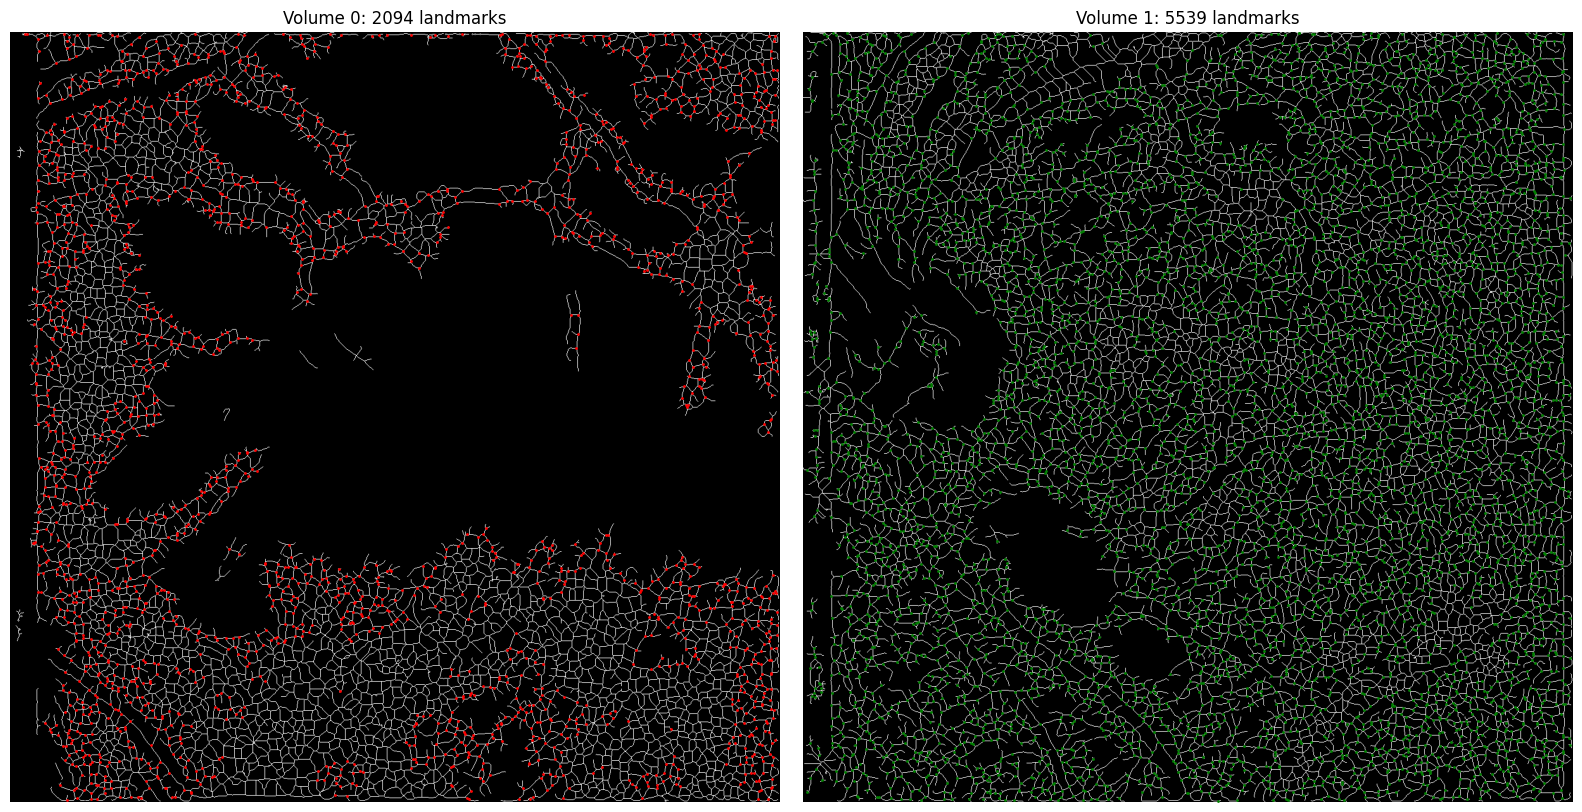

In [2]:
# Load bifurcation coordinates
bifurcations_v0 = np.load(data_dir / 'bifurcation_coords_volume0.npy')
bifurcations_v1 = np.load(data_dir / 'bifurcation_coords_volume1.npy')

# Load vessel skeletons for visualization
skeleton_v0 = np.load(data_dir / 'vessel_skeleton_volume0.npy')
skeleton_v1 = np.load(data_dir / 'vessel_skeleton_volume1.npy')

print(f"Volume 0: {len(bifurcations_v0)} bifurcations")
print(f"Volume 1: {len(bifurcations_v1)} bifurcations")
print(f"\nSkeleton shapes: {skeleton_v0.shape}, {skeleton_v1.shape}")

# Visualize initial state
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(skeleton_v0, cmap='gray')
axes[0].plot(bifurcations_v0[:, 1], bifurcations_v0[:, 0], 'r.', markersize=2)
axes[0].set_title(f'Volume 0: {len(bifurcations_v0)} landmarks')
axes[0].axis('off')

axes[1].imshow(skeleton_v1, cmap='gray')
axes[1].plot(bifurcations_v1[:, 1], bifurcations_v1[:, 0], 'g.', markersize=2)
axes[1].set_title(f'Volume 1: {len(bifurcations_v1)} landmarks')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 2: Match Bifurcations Using Nearest Neighbor + RANSAC

We'll use a simple but robust approach:
1. Find nearest neighbors between the two point sets
2. Use RANSAC to robustly estimate translation despite mismatches

In [3]:
def match_bifurcations_ransac(points_src, points_dst, max_distance=50, min_samples=10):
    """
    Match bifurcations using nearest neighbor + RANSAC for robust translation estimation.
    
    Args:
        points_src: Source bifurcations (N, 2) - volume 1
        points_dst: Destination bifurcations (M, 2) - volume 0 (reference)
        max_distance: Maximum distance for a match to be considered
        min_samples: Minimum samples for RANSAC
    
    Returns:
        translation: (dy, dx) offset to align src to dst
        inlier_mask: Boolean mask of inlier matches
        matches: Array of (src_idx, dst_idx) pairs
    """
    # Find nearest neighbors
    distances = cdist(points_src, points_dst)
    
    # For each source point, find closest destination point
    nearest_indices = np.argmin(distances, axis=1)
    nearest_distances = np.min(distances, axis=1)
    
    # Filter by maximum distance
    valid_mask = nearest_distances < max_distance
    
    src_matched = points_src[valid_mask]
    dst_matched = points_dst[nearest_indices[valid_mask]]
    
    print(f"Initial nearest neighbor matches: {len(src_matched)}")
    
    if len(src_matched) < min_samples:
        print(f"Warning: Only {len(src_matched)} matches found, need at least {min_samples}")
        return None, None, None
    
    # Calculate displacement vectors
    displacements = dst_matched - src_matched  # (N, 2) array of (dy, dx)
    
    # Use RANSAC to robustly estimate translation
    # We'll fit dy and dx separately for simplicity
    ransac_y = RANSACRegressor(random_state=42, min_samples=min_samples)
    ransac_x = RANSACRegressor(random_state=42, min_samples=min_samples)
    
    # Dummy X for RANSAC (we're just finding the median translation)
    X = np.arange(len(displacements)).reshape(-1, 1)
    
    ransac_y.fit(X, displacements[:, 0])
    ransac_x.fit(X, displacements[:, 1])
    
    # Get inliers (points that agree with the estimated translation)
    inlier_mask = ransac_y.inlier_mask_ & ransac_x.inlier_mask_
    
    # Calculate final translation from inliers
    translation = np.median(displacements[inlier_mask], axis=0)
    
    print(f"RANSAC inliers: {inlier_mask.sum()} / {len(inlier_mask)}")
    print(f"Estimated translation (dy, dx): ({translation[0]:.2f}, {translation[1]:.2f}) pixels")
    
    # Create match pairs
    src_indices = np.where(valid_mask)[0]
    matches = np.column_stack([src_indices, nearest_indices[valid_mask]])
    
    return translation, inlier_mask, matches

# Perform matching
translation, inlier_mask, matches = match_bifurcations_ransac(
    bifurcations_v1,  # Source (to be aligned)
    bifurcations_v0,  # Destination (reference)
    max_distance=100,
    min_samples=20
)

Initial nearest neighbor matches: 5061
RANSAC inliers: 1696 / 5061
Estimated translation (dy, dx): (0.00, 0.00) pixels


## Step 3: Visualize Matches

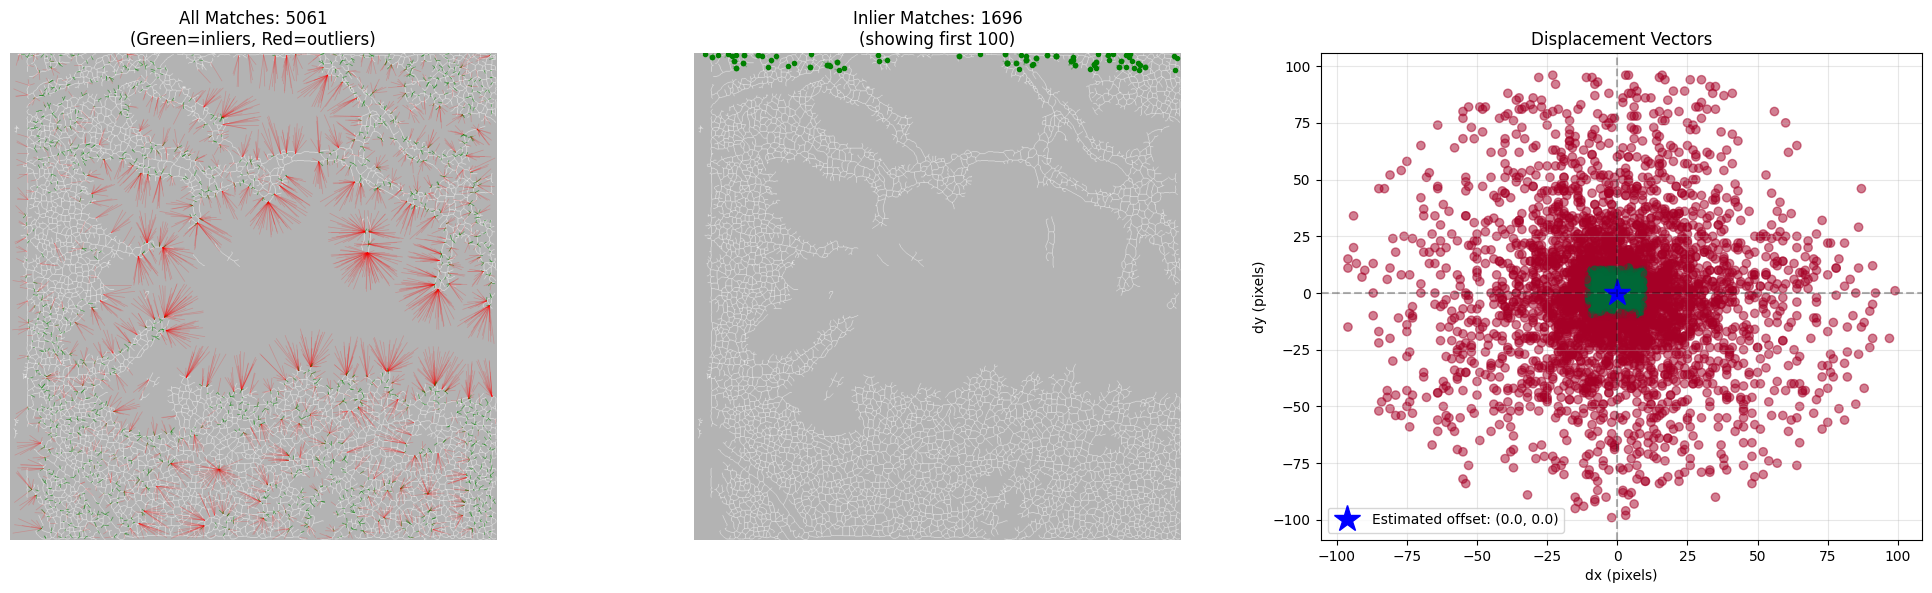

In [4]:
if translation is not None:
    # Show matched points
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # All matches
    axes[0].imshow(skeleton_v0, cmap='gray', alpha=0.3)
    for i, (src_idx, dst_idx) in enumerate(matches):
        color = 'g' if inlier_mask[i] else 'r'
        alpha = 0.6 if inlier_mask[i] else 0.2
        src_pt = bifurcations_v1[src_idx]
        dst_pt = bifurcations_v0[dst_idx]
        axes[0].plot([src_pt[1], dst_pt[1]], [src_pt[0], dst_pt[0]], 
                    color=color, alpha=alpha, linewidth=0.5)
    axes[0].set_title(f'All Matches: {len(matches)}\n(Green=inliers, Red=outliers)')
    axes[0].axis('off')
    
    # Inliers only
    axes[1].imshow(skeleton_v0, cmap='gray', alpha=0.3)
    inlier_matches = matches[inlier_mask]
    for src_idx, dst_idx in inlier_matches[:100]:  # Show first 100
        src_pt = bifurcations_v1[src_idx]
        dst_pt = bifurcations_v0[dst_idx]
        axes[1].plot([src_pt[1], dst_pt[1]], [src_pt[0], dst_pt[0]], 
                    'g-', alpha=0.3, linewidth=1)
        axes[1].plot(dst_pt[1], dst_pt[0], 'go', markersize=3)
    axes[1].set_title(f'Inlier Matches: {inlier_mask.sum()}\n(showing first 100)')
    axes[1].axis('off')
    
    # Displacement distribution
    displacements = bifurcations_v0[matches[:, 1]] - bifurcations_v1[matches[:, 0]]
    axes[2].scatter(displacements[:, 1], displacements[:, 0], 
                   c=inlier_mask, cmap='RdYlGn', alpha=0.5)
    axes[2].plot(translation[1], translation[0], 'b*', markersize=20, 
                label=f'Estimated offset: ({translation[0]:.1f}, {translation[1]:.1f})')
    axes[2].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[2].axvline(0, color='k', linestyle='--', alpha=0.3)
    axes[2].set_xlabel('dx (pixels)')
    axes[2].set_ylabel('dy (pixels)')
    axes[2].set_title('Displacement Vectors')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Matching failed - not enough correspondences found")

## Step 4: Apply Registration and Visualize Results

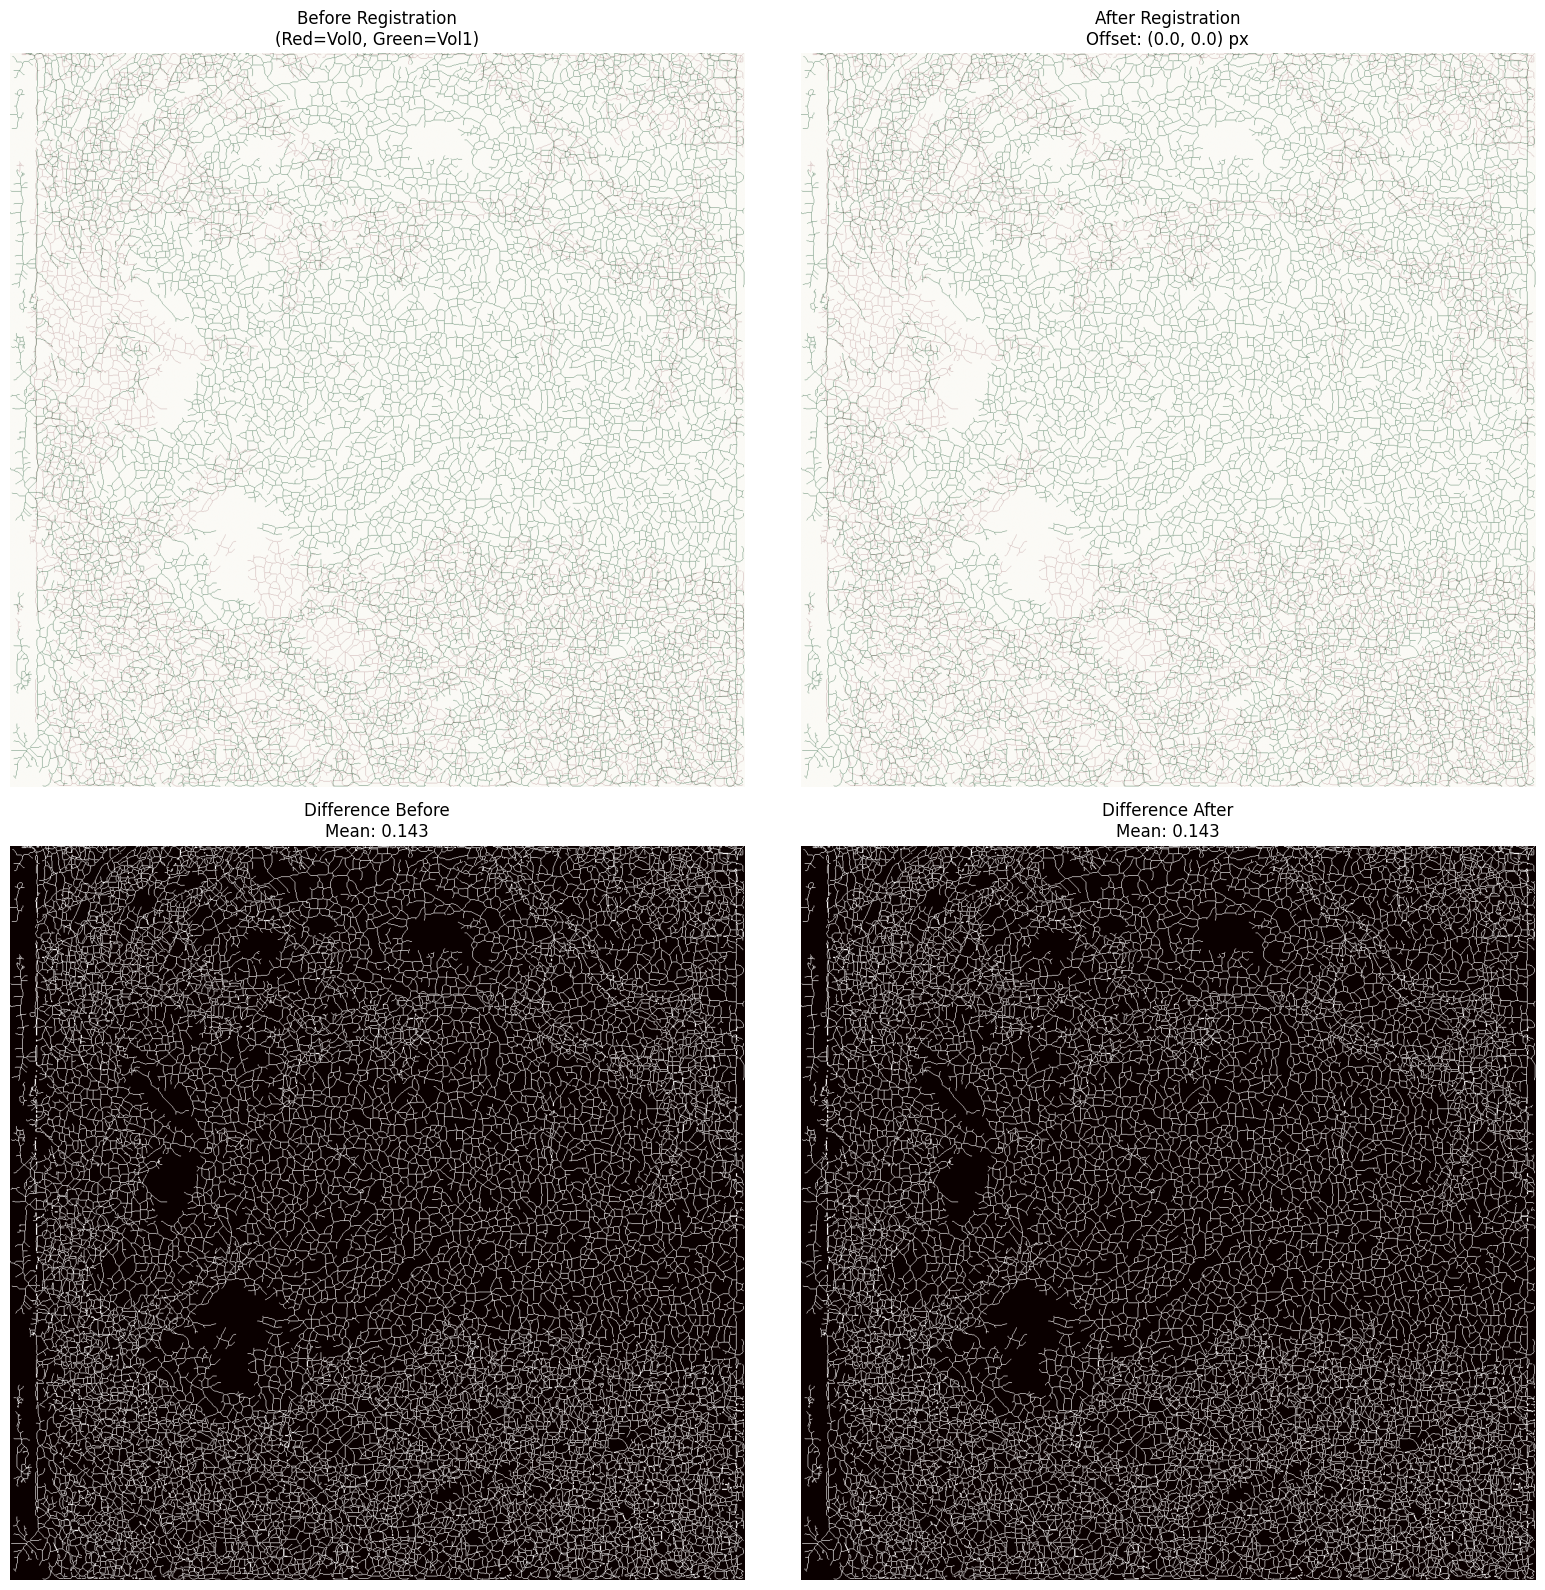

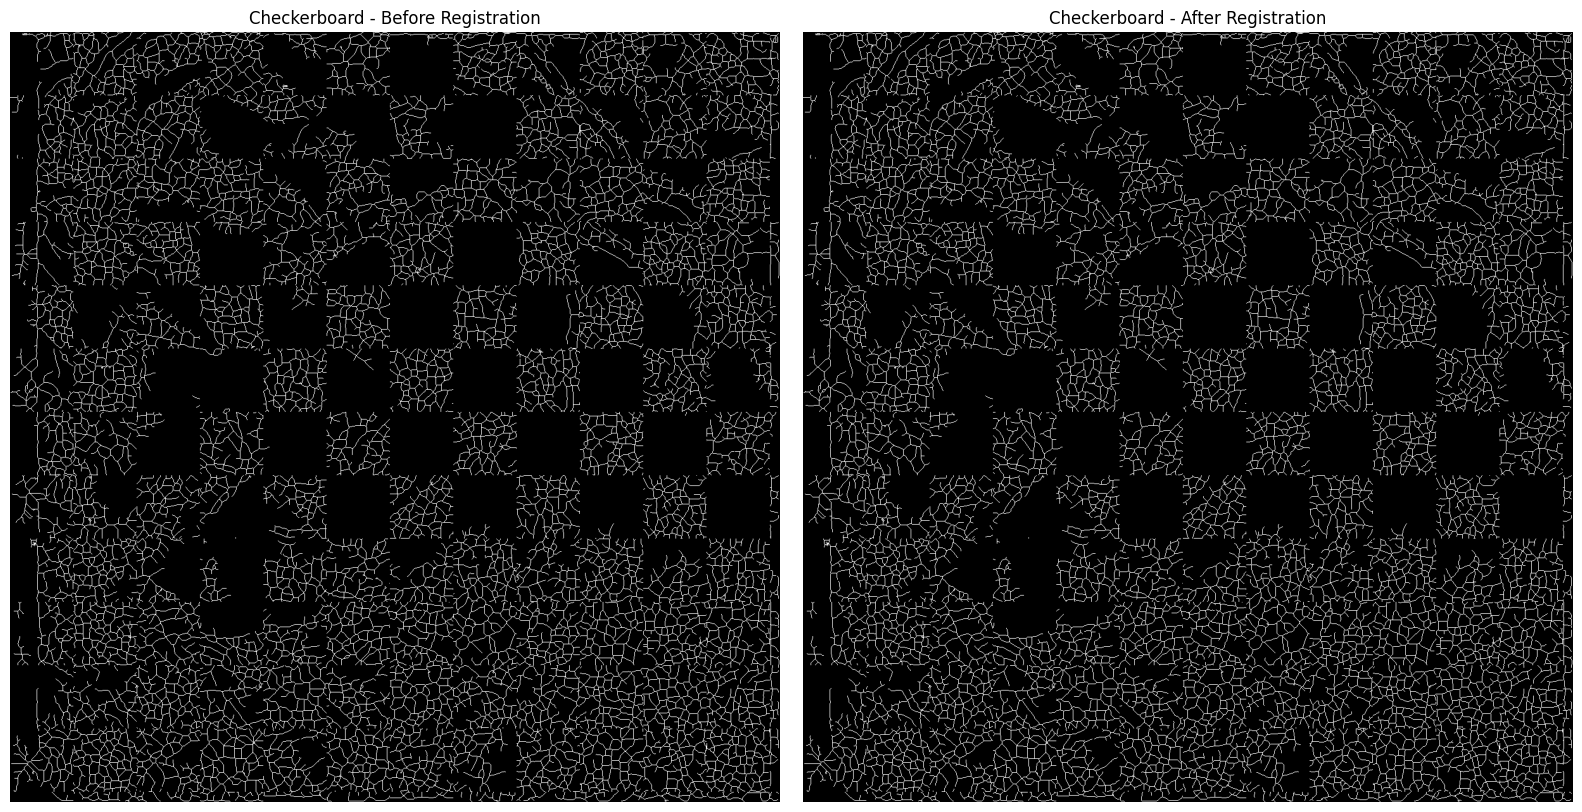


📊 Registration Quality Metrics:
  Translation: dy=0.00, dx=0.00 pixels
  Inlier matches: 1696 / 5061 (33.5%)
  Mean difference before: 0.1432
  Mean difference after: 0.1432
  Improvement: 0.0%


In [5]:
if translation is not None:
    # Apply translation to volume 1 skeleton
    skeleton_v1_aligned = shift(skeleton_v1, shift=translation, order=0, mode='constant', cval=0)
    
    # Also shift bifurcation coordinates
    bifurcations_v1_aligned = bifurcations_v1 + translation
    
    # Visualize before/after
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Before: Overlay unaligned
    axes[0, 0].imshow(skeleton_v0, cmap='Reds', alpha=0.5)
    axes[0, 0].imshow(skeleton_v1, cmap='Greens', alpha=0.5)
    axes[0, 0].set_title('Before Registration\n(Red=Vol0, Green=Vol1)')
    axes[0, 0].axis('off')
    
    # After: Overlay aligned
    axes[0, 1].imshow(skeleton_v0, cmap='Reds', alpha=0.5)
    axes[0, 1].imshow(skeleton_v1_aligned, cmap='Greens', alpha=0.5)
    axes[0, 1].set_title(f'After Registration\nOffset: ({translation[0]:.1f}, {translation[1]:.1f}) px')
    axes[0, 1].axis('off')
    
    # Difference before
    diff_before = np.abs(skeleton_v0.astype(float) - skeleton_v1.astype(float))
    axes[1, 0].imshow(diff_before, cmap='hot')
    axes[1, 0].set_title(f'Difference Before\nMean: {diff_before.mean():.3f}')
    axes[1, 0].axis('off')
    
    # Difference after
    diff_after = np.abs(skeleton_v0.astype(float) - skeleton_v1_aligned.astype(float))
    axes[1, 1].imshow(diff_after, cmap='hot')
    axes[1, 1].set_title(f'Difference After\nMean: {diff_after.mean():.3f}')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Checkerboard visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Create checkerboard pattern
    checker_size = 100
    h, w = skeleton_v0.shape
    checkerboard = np.zeros((h, w), dtype=bool)
    for i in range(0, h, checker_size):
        for j in range(0, w, checker_size):
            if ((i // checker_size) + (j // checker_size)) % 2 == 0:
                checkerboard[i:i+checker_size, j:j+checker_size] = True
    
    # Before
    checker_before = skeleton_v0.copy()
    checker_before[~checkerboard] = skeleton_v1[~checkerboard]
    axes[0].imshow(checker_before, cmap='gray')
    axes[0].set_title('Checkerboard - Before Registration')
    axes[0].axis('off')
    
    # After
    checker_after = skeleton_v0.copy()
    checker_after[~checkerboard] = skeleton_v1_aligned[~checkerboard]
    axes[1].imshow(checker_after, cmap='gray')
    axes[1].set_title('Checkerboard - After Registration')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Registration Quality Metrics:")
    print(f"  Translation: dy={translation[0]:.2f}, dx={translation[1]:.2f} pixels")
    print(f"  Inlier matches: {inlier_mask.sum()} / {len(matches)} ({100*inlier_mask.sum()/len(matches):.1f}%)")
    print(f"  Mean difference before: {diff_before.mean():.4f}")
    print(f"  Mean difference after: {diff_after.mean():.4f}")
    print(f"  Improvement: {100*(1 - diff_after.mean()/diff_before.mean()):.1f}%")
else:
    print("⚠ Cannot apply registration - matching failed")

## Step 5: Save Registration Results

In [6]:
if translation is not None:
    # Save registration parameters
    registration_params = {
        'translation_yx': translation.tolist(),
        'num_matches': len(matches),
        'num_inliers': int(inlier_mask.sum()),
        'inlier_ratio': float(inlier_mask.sum() / len(matches)),
        'mean_diff_before': float(diff_before.mean()),
        'mean_diff_after': float(diff_after.mean())
    }
    
    np.save(data_dir / 'xy_registration_params.npy', registration_params)
    np.save(data_dir / 'skeleton_v1_aligned.npy', skeleton_v1_aligned)
    np.save(data_dir / 'bifurcations_v1_aligned.npy', bifurcations_v1_aligned)
    
    print("✓ Saved registration results:")
    print(f"  - xy_registration_params.npy")
    print(f"  - skeleton_v1_aligned.npy")
    print(f"  - bifurcations_v1_aligned.npy")
    
    print("\n✓ Phase 3 XY registration complete!")
    print("\nNext steps:")
    print("  1. Apply same XY translation to full OCT volumes")
    print("  2. Phase 4: Z-axis (depth) alignment using retinal layers")
    print("  3. Verify final 3D registration")
else:
    print("⚠ Cannot save - registration failed")

✓ Saved registration results:
  - xy_registration_params.npy
  - skeleton_v1_aligned.npy
  - bifurcations_v1_aligned.npy

✓ Phase 3 XY registration complete!

Next steps:
  1. Apply same XY translation to full OCT volumes
  2. Phase 4: Z-axis (depth) alignment using retinal layers
  3. Verify final 3D registration
